In [1]:
import os
import sys
sys.path.append('/Users/abdielfer/RNCanWork/DL4Flood/')
from model_set.models import UNetFlood
from scr import util as U
from scr import dataLoader as D
from scr import models_trainer
from scr import losses as L
from scr.losses import iou_binary,binaryAccuracy
from rasterio.plot import show
import torch
from torch import nn
from torch.optim import Adam, SGD
import numpy as np

C:\Users\abfernan\.conda\envs\geo_deep_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from rasterio.plot import show
maskPath = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\trn\exp1\testPermanentTransf\mask\ON_VilleGatineau_440125_7778218668_5037429_508255529_feat1_min-annot10.tif'
saveMaskDir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\trn\exp1\testPermanentTransf\mask'
# maskCopy = U.makeFileCopy(maskPath,saveMaskDir)
# print(maskCopy)

mask,profil = U.readRaster(maskPath)
_,imgName,imgExt= U.get_parenPath_name_ext(maskPath)
maskPath = os.path.join(saveMaskDir,imgName+'transf'+imgExt)
# U.createRaster(maskPath, mask, profil)
# show(mask)
# rotMask = np.rot90(mask)
# show(rotMask)

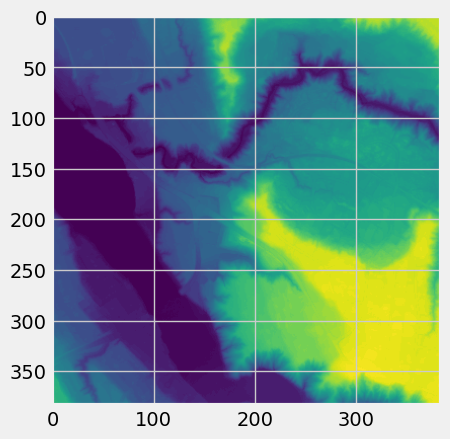

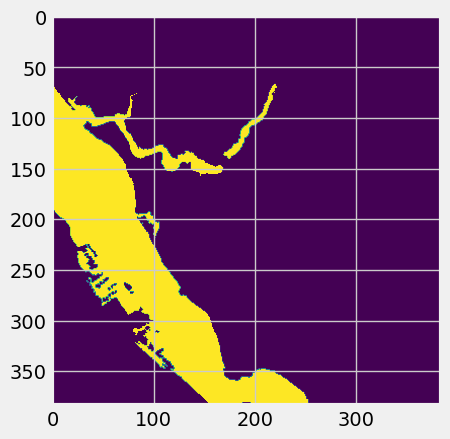

<Axes: >

In [2]:
from rasterio.plot import show
saveImgDir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\trn\exp1\testPermanentTransf\img'
saveMaskDir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\trn\exp1\testPermanentTransf\mask'
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\TestPermanentTransf.csv'

lastRotImag, lastRotMask = D.offlineTransformation(scvPath,saveImgDir,saveMaskDir) 
show(lastRotImag)
show(lastRotMask)

In [ ]:
### Transfer images by copy
img_list, mask_list = D.createImageMaskList(scvPath)
for i, m in zip(img_list, mask_list):
    U.makeFileCopy(i,saveImgDir)
    U.makeFileCopy(m,saveMaskDir)

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

# testing train cycle

In [ ]:
datalistPath = r'\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\percentage_1_feat1_min-annot10_trn.csv'

# NOTE: We need to put r in front of the string, to denote raw string. Otherwise,'_' character will truncate the string 
args = {'batch_size': 1, 'num_workers': 1,'drop_last': True}

fullSet = D.customDataSet(datalistPath)
img,mask=fullSet.__getitem__(0)
trainSet, valSet = D.splitDataset(fullSet)
print(f"Dataset lens : train: {trainSet.__len__()} :-- valSet: {valSet.__len__()}")

train_set = D.customDataloader(trainSet,args)  #.getDataloader()     
val_set = D.customDataloader(valSet,args)  #.getDataloader()
# rasterPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/trn/VilleGatineau-1/images/'


In [ ]:
datalistPath = r'\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\TestPermanentTransf.csv'
savePath = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\val'
TransfoSet = D.customDataSet(datalistPath)
#D.offlineTransformation(TransfoSet,savePath,savePath)

In [ ]:
model = UNetFlood(1,1)
# loss_fn = nn.CrossEntropyLoss() if model.classes > 1 else nn.BCEWithLogitsLoss()
loss_fn = L.lovasz_hinge

optimizer = Adam(model.parameters(), lr = 0.0001) #SGD(model.parameters(), lr=0.0001, momentum=0.9)##  

trainer = models_trainer.models_trainer(model,loss_fn,optimizer, iou_binary)
trainer.set_loaders(train_set,val_set)

In [ ]:
trainer.train(10)

In [ ]:
trainer.load_checkpoint('2304061151')

In [ ]:
item = next(iter(val_set))
imag = item[0]
mask = item[1]
print('image to model input shape',imag.shape)

model.eval()
Y_hat = model(imag)
print('Y_hat to model input shape',Y_hat.shape)
model.train()


In [ ]:
for i in range(0,imag.shape[0]):
    U.plotImageAndMask(Y_hat[i][0], mask[i][0])


In [ ]:
##  Works well!
# Testing util.makePredictionRaster() for inference.
inToInfer,_ = U.readRaster(rasterPath)

imgToInferTensor = U.imageToTensor(inToInfer)
print("imgToInferTensor shape: ----", imgToInferTensor.shape)
out = U.makePredictionRaster(rasterPath, model,saveRaster=True)
print('out shape: _____ ',out.shape)


In [ ]:
#test IoU
# Modified mask: righ up corner have been removed from real mask in QGIS. Both share CRS, resolution, ect. 
parentDir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\SyntheticPredictionandMask'
realMask = 'mask1.tif'
modifiedMask = 'SintheticGT1_1.tif'

maskPath = os.path.join(parentDir,realMask)
gtPath = os.path.join(parentDir, modifiedMask)
print(maskPath, gtPath)

real,_ = U.readRaster(maskPath)
modified,_ = U.readRaster(gtPath)

ioUB = iou_binary(real,modified)
print(f"iou_binary : {ioUB}")

realTensor = U.imageToTensor(real)
modifiedTensor = U.imageToTensor(modified)

print(f"binaryAccuracy : {binaryAccuracy(realTensor,modifiedTensor)}")

U.plotImageAndMask(U.imageToTensor(real)[0],U.imageToTensor(modified)[0],'original mask','modified mask')

#  OUTPUT = 87,987% iou, is a good representation of mask differences. 

In [ ]:
U.plotImageAndMask(imgToInferTensor[0],rasterData[0])

In [ ]:
import torch as T
from torch.autograd import Variable

In [ ]:
flated = Y_hat[0][0].view(-1)
signs = 2. * Y_hat[0][0].float() - 1.
# print(Y_hat[0][0][0:20,340:350])
# print('signe : ____',signs[0:20,340:350])
# print(signs.shape)
zerosAndOnes = torch.where(signs==-1,torch.tensor(0),signs)
# print(zerosAndOnes[0:20,340:350])
errors = (1. - Y_hat[0][0] * Variable(signs))
U.plotImageAndMask(Y_hat[0][0], zerosAndOnes)
ioUB = L.iou_binary(zerosAndOnes,zerosAndOnes, per_image=False)
print(ioUB)

In [ ]:
####   Apply sigmoid to the output image to compare with Mask...IMportant!!!!
y_hatSigmoided = torch.sigmoid(Y_hat[0][0])
U.plotImageAndMask(y_hatSigmoided, mask[0][0])

In [ ]:
### Visualize all batch image-mask pairs. 
# NOTE :   img, mask = next(iter(train_set))
i = 0
j = 0
for batch in train_set:
    for item in batch:
        print(f"Bathc {i}, item {j}")
        print('item',item.shape)
        j +=1
        
    # U.plotImageAndMask(batch[0][0],batch[1][0])
    i+=1
    j=0  
    print("_______") 


# Things to test: 
## Image visualization.

In [ ]:
## Ref: 

from typing import Iterable, List
import torch
import matplotlib.pyplot as plt

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='gray')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

In [ ]:

from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()
     

idx = 0
img = xr.open_rasterio(train_imgs[idx])
mask = xr.open_rasterio(train_masks[idx])
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')

# Cleaning sampling from GDL.
### GDL sampling includes images with no mask matching. In this section we remove unnecessary files.  

In [ ]:
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\percentage_1_feat1_min-annot10_trn.csv'
# tifDirPath = r''

In [ ]:
import csv
 
# open the file in read mode
filename = open(scvPath, 'r')
 
# creating dictReader object
file = csv.DictReader(filename)
print(file)

In [ ]:
import pandas as pd
csvPath = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\TestPermanentTransf.csv'
fields = ['image', 'mask', '%']
df = pd.read_csv(csvPath,index_col = None, delimiter = ';')
print(df.shape)

In [ ]:
# 1-recorrer el directorio y crear lista de todos los *.tif. 2-importar *.csv list of images and mask.
# 3-compara cada nombre en la lista de *.tif con los de la lista from *.csv, 4- si no esta en la lista, borrar.
from scr import util as U
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\percentage_1_feat1_min-annot10_trn.csv'
tifDir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\trn\exp1\images'
Dir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\TestTiling\percentage_1\trn\exp1'

tifList = U.listALLFilesInDirByExt(Dir, ext='.tif')
print(f"Jupyter Nbk All available *tif :  {len(tifList)}")
noMatchList = U.noMatch_TifMask_List(scvPath,tifDir)

## Check in for Operative System

In [ ]:
from sys import platform
def getPlatform():
    OPS = ''
    if platform == "darwin":
        OPS = "mac"
    elif platform == "win32":
        OPS = "win"
    return OPS 

####   

OPS = getPlatform()

if OPS == 'mac': 
    configPath = 'config\configMac.yaml'
elif OPS == 'win':
    configPath = 'config\configPC.yaml'

print(OPS)